In this project you will:

Create custom dataset for Localization problems

Apply augmentations for localization task and load pretrained model 

Create train function and evaluator for training loop

# Task 1: Imports

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pc3dpttn
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pc3dpttn
     |████████████████████████████████| 47.8 MB 2.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=7a287f6a6742c48b719009905c2d75e63d97df9a6e7b1660190817600a92305b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7nedlzib/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 431 kB 5.2 MB/s 
     |████████████████████████████████| 66.7 MB 21 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 12.79 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Task 2: Configurations

In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40

MODEL_NAME = 'efficientnet_b0' # we can choose different networks

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Task 3: Explore the dataset

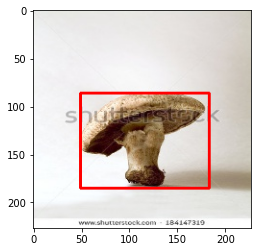

In [10]:
row = df.iloc[2] # 2th row of df
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Using cv2.COLOR_BGR2RGB color space
lc, rc = (row.xmin, row.ymin), (row.xmax, row.ymax)
bbox_img = cv2.rectangle(img, lc, rc, (255., 0., 0.), 2)
plt.imshow(bbox_img)

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=13)

# Task 4: Data Augmentation

In [12]:
import albumentations as A

In [23]:
train_augs = A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Rotate()
],
bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)],
  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Task 5: Create custom dataset

In [24]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img = cv2.imread(DATA_DIR + row.img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bbox = [[row.xmin, row.ymin, row.xmax, row.ymax]]

    if self.augmentations:
      data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
      img = data['image']
      bbox = data['bboxes'][0] # bbox[0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # .permute() changes axis from (h, w, c) -> (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox



In [25]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [26]:
print(f"Total examples in the train set: {len(trainset)}")
print(f"Total examples in the valid set: {len(validset)}")

Total examples in the train set: 148
Total examples in the valid set: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


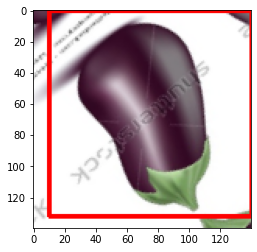

In [29]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Task 6: Load dataset into batches

In [30]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [32]:
for images, bboxes in trainloader:
  break
print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Task 7: Create Model

In [33]:
from torch import nn
import timm

In [34]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4) # output is logits

  def forward(self, images, gt_bboxes=None): # ground truth bbox
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [35]:
model = ObjLocModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [36]:
# CHECK OUTPUT SHAPE
random_img = torch.rand(1, 3, 140, 140).to(DEVICE) #(batch_size, channel, h, w)
model(random_img).shape


torch.Size([1, 4])

# Task 8: Create training and evaluation functions

In [37]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.
  model.train() # Dropout is ON

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

def eval_fn(model, dataloader):
  total_loss = 0.
  model.eval() # Dropout is OFF

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)

      total_loss += loss.item()

  return total_loss/len(dataloader)

# Task 9: Training loop

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [39]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("MODEL SAVED.")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1}, train loss: {train_loss}, valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 1, train loss: 5504.082299804688, valid loss: 1366.50830078125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2, train loss: 1994.8865600585937, valid loss: 2846.296183268229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 3, train loss: 1294.5458862304688, valid loss: 192.5687713623047


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4, train loss: 858.9986877441406, valid loss: 199.3108673095703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 5, train loss: 607.83125, valid loss: 136.0241241455078


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6, train loss: 484.1544921875, valid loss: 250.31436157226562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7, train loss: 387.78369140625, valid loss: 171.3191375732422


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 8, train loss: 255.16033020019532, valid loss: 112.29913075764973


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 9, train loss: 238.92166137695312, valid loss: 83.41770935058594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10, train loss: 192.25316925048827, valid loss: 105.54611714680989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 11, train loss: 142.9679801940918, valid loss: 74.01103210449219


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12, train loss: 178.3313835144043, valid loss: 89.92254892985027


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 13, train loss: 119.33012924194335, valid loss: 72.87068939208984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14, train loss: 101.38714370727538, valid loss: 76.65989939371745


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15, train loss: 97.15389595031738, valid loss: 85.2683817545573


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16, train loss: 106.26554565429687, valid loss: 94.5239969889323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17, train loss: 107.82797470092774, valid loss: 80.16346486409505


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18, train loss: 88.43604164123535, valid loss: 108.97224426269531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 19, train loss: 94.34826278686523, valid loss: 63.3067372639974


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 20, train loss: 71.3605125427246, valid loss: 57.22413762410482


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 21, train loss: 78.6795093536377, valid loss: 50.71125157674154


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22, train loss: 76.82435493469238, valid loss: 53.569939931233726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 23, train loss: 69.46289863586426, valid loss: 46.07461675008138


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 24, train loss: 72.38434085845947, valid loss: 44.80989074707031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25, train loss: 69.08411827087403, valid loss: 47.525885264078774


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26, train loss: 75.66657905578613, valid loss: 55.64357376098633


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED.
Epoch: 27, train loss: 63.868661880493164, valid loss: 35.77517827351888


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28, train loss: 47.56709098815918, valid loss: 73.73301188151042


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29, train loss: 56.80737724304199, valid loss: 56.03722890218099


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30, train loss: 48.346655464172365, valid loss: 46.116949717203774


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31, train loss: 54.46238994598389, valid loss: 45.90168889363607


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32, train loss: 50.696221351623535, valid loss: 83.50753275553386


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33, train loss: 60.71476440429687, valid loss: 41.398271560668945


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34, train loss: 60.14135055541992, valid loss: 49.73810577392578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35, train loss: 51.97276420593262, valid loss: 37.621652603149414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36, train loss: 47.59853973388672, valid loss: 42.71854019165039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37, train loss: 39.84501438140869, valid loss: 45.33659362792969


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38, train loss: 44.81106700897217, valid loss: 43.86192194620768


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39, train loss: 52.31610927581787, valid loss: 39.72878774007162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40, train loss: 42.03370113372803, valid loss: 49.62181727091471


# Task 10: Inference

In [40]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


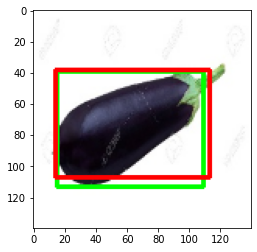

In [44]:
model.load_state_dict(torch.load('/content/best_model.pt'))
model.eval()

idx = 1
with torch.no_grad():
  image, gt_bbox = validset[idx] # (C, H, W)
  image = image.unsqueeze(0).to(DEVICE) # (BATCH_SIZE, C, H, W)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox) # green: gt, red: pred